# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Luis Fernando Ramirez Ramos

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

In [2]:
import re
import sys
import hashlib
import unicodedata
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import (
    udf, avg, trim, col, count, isnull, when, lit, concat, round, asc, desc,
    input_file_name, current_timestamp, struct, min, least, array_size, length,
    row_number, collect_list, array, explode, size, concat as spark_concat
)
from datetime import datetime
from fernandoramos.spark_utils import SparkUtils

spark = SparkSession.builder \
    .appName("Car catalogue normalization and match.") \
    .master("spark://3fc414c80e1d:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/28 10:55:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Introduction

I will build a compact batch data pipeline in PySpark that ingests five CSV catalogues from real insurers (Zurich, HDI, Quálitas, Chubb, El Potosí), normalizes core attributes (brand, model, year, transmission), and writes a master catalog to PostgreSQL (both run locally in Docker).

### Matching strategy:

#### Commercial hash candidates 
I form a deterministic key from normalized (brand, model, year, transmission) to find matches across insurers.

### Second meant strategy (out of scope)

#### Version similarity 
I meant to normalize the free-text version_original into a single cleaned field version_clean (keeping all specs together) in order to create tighter and more accurate matches. Versions would then be compared using Jaccard similarity (set overlap) and a coverage index (bidirectional overlap) to confirm real matches.

This matching layer was discarted since it seems to be too expensive in CPU and memory, since a lot of comparisons were needed. This strategies are not used, but they were kept at the end of the code for a possible future implementation.

# Dataset

The input data is extracted from real insurers’ vehicle catalogues. Each CSV row is one vehicle entry as published by the insurer.

Raw fields: origen, id_original, marca, modelo, anio, version_original, transmision, activo

#### origen 
Insurer code/name the row comes from (e.g., ZURICH, HDI).

#### id_original 
The insurer’s primary/row identifier (keep as string to avoid overflow or formatting issues).

#### marca 
Vehicle brand as provided by the insurer (will be uppercased/canonicalized later).

#### modelo 
Vehicle model name as provided (to be normalized).

#### anio 
Model year (integer).

#### version_original 
Free-text trim/spec line (contains trim, HP, doors, body type, etc.).

#### transmision 
Transmission as provided; may be blank/messy; later normalized to AUTO or MANUAL.

#### activo 
Row activity flag from the source; typically 1/0 or boolean; we’ll filter to active rows.

# Transformations and Actions

### Define Input Schema

In [3]:
raw_vehicle_data_schema = SparkUtils.generate_schema([
    ("origen_aseguradora", "string", True),
    ("id_original", "string", True),
    ("marca", "string", True),
    ("modelo", "string", True),
    ("anio", "int", True),
    ("version_original", "string", True),
    ("transmision", "string", True), # {AUTO, MANUAL}
    ("activo", "string", True) 
])

print("Schema generated.")

Schema generated.


### Origin Data Load

In [4]:
vehicle_dataset = spark \
  .read \
  .format("csv") \
  .option("header", "true") \
  .option("quote", '"') \
  .option("escape", '"') \
  .option("mode", "PERMISSIVE") \
  .schema(raw_vehicle_data_schema) \
  .csv("/opt/spark/work-dir/data/insurers/")

# Add metadata columns 
vehicle_dataset = vehicle_dataset \
  .withColumn("source_file", input_file_name()) \
  .withColumn("ingestion_ts", current_timestamp()) \
  .withColumnRenamed("origen_aseguradora", "origen")

# Safe conversion of activo from string to int
# Malformed rows will have NULL in activo_int
vehicle_dataset = vehicle_dataset.withColumn(
  "activo_int",
  when(col("activo").rlike("^[0-9]+$"), col("activo").cast("int"))
  .otherwise(None)
)

### Filter only valid data

In [5]:
current_year = datetime.now().year

vehicle_dataset_filtered = vehicle_dataset \
  .filter(col("activo_int") == 1) \
  .filter(col("marca").isNotNull() & (col("marca") != "")) \
  .filter(col("modelo").isNotNull() & (col("modelo") != "")) \
  .filter(col("anio").isNotNull()) \
  .filter((col("anio") >= 2000) & (col("anio") <= current_year + 1)) \
  .drop("activo") \
  .withColumnRenamed("activo_int", "activo")

### Normalization Functions

In [6]:
from normalization_config import (
    BRAND_ALIASES, MODEL_ALIASES, TRANSMISSION_KEYWORDS,
    UNIT_MAPPINGS, SYNONYM_MAPPINGS, TOKEN_EXCLUSIONS
)

# Helper function: Remove accents
def remove_accents(text):
    if not text:
        return text
    nfd = unicodedata.normalize('NFD', text)
    return ''.join([c for c in nfd if unicodedata.category(c) != 'Mn'])

print("Config imported successfully")
print(f"   - Brand aliases: {len(BRAND_ALIASES)} mappings")
print(f"   - Model aliases: {len(MODEL_ALIASES)} mappings")
print(f"   - Transmission keywords: {len(TRANSMISSION_KEYWORDS)} mappings")
print(f"   - Token exclusions: {len(TOKEN_EXCLUSIONS)} tokens")

Config imported successfully
   - Brand aliases: 23 mappings
   - Model aliases: 33 mappings
   - Transmission keywords: 21 mappings
   - Token exclusions: 108 tokens


### Brand and Model Normalization Functions

In [7]:
def normalize_brand_model(value, aliases_dict):
    if not value or value.strip() == "":
        return value
    
    # Uppercase and trim
    normalized = str(value).upper().strip()
    
    # Remove accents
    normalized = remove_accents(normalized)
    
    # Collapse multiple spaces
    normalized = re.sub(r'\s+', ' ', normalized)
    
    # Apply alias mapping
    if normalized in aliases_dict:
        normalized = aliases_dict[normalized]
    
    return normalized

# Create UDFs for brand and model
normalize_brand_udf = udf(
    lambda x: normalize_brand_model(x, BRAND_ALIASES), 
    "string"
)
normalize_model_udf = udf(
    lambda x: normalize_brand_model(x, MODEL_ALIASES), 
    "string"
)

### Transmission Normalization Function

In [8]:
def infer_transmission(transmision_field, version_original):
    # Normalize transmission to AUTO or MANUAL
    # First try the transmision field
    if transmision_field and transmision_field.strip():
        trans_upper = transmision_field.upper().strip()
        
        # Check if it matches any keyword
        for keyword, canonical in TRANSMISSION_KEYWORDS.items():
            if keyword in trans_upper:
                return canonical
    
    # If empty or no match, try to infer from version_original
    if version_original and version_original.strip():
        version_upper = version_original.upper().strip()
        
        for keyword, canonical in TRANSMISSION_KEYWORDS.items():
            if keyword in version_upper:
                return canonical
    
    # Return None if cannot infer 
    return None

normalize_transmission_udf = udf(infer_transmission, "string")

### Commercial Hash Function

In [9]:
def compute_commercial_hash(brand_norm, model_norm, year, transmission_norm):
    # Commercial_hash = SHA-256(brand_norm|model_norm|year|transmission_norm)
    if not all([brand_norm, model_norm, year, transmission_norm]):
        return None
    
    # Create composite key
    composite_key = f"{brand_norm}|{model_norm}|{year}|{transmission_norm}"
    
    # Compute SHA-256 hash
    hash_obj = hashlib.sha256(composite_key.encode('utf-8'))
    return hash_obj.hexdigest()

compute_commercial_hash_udf = udf(compute_commercial_hash, "string")

## Apply Normalization Pipeline

In [10]:
# Apply all normalization UDFs and build disponibilidad struct
df_catalog_clean = vehicle_dataset_filtered \
    .withColumn("brand_norm", normalize_brand_udf(col("marca"))) \
    .withColumn("model_norm", normalize_model_udf(col("modelo"))) \
    .withColumn("year", col("anio")) \
    .withColumn("transmission_norm", normalize_transmission_udf(col("transmision"), col("version_original"))) \
    .withColumn("commercial_hash", compute_commercial_hash_udf(
        col("brand_norm"), col("model_norm"), col("year"), col("transmission_norm")
    )) \
    .withColumn("disponibilidad", struct(
        col("origen"),
        col("id_original"),
        col("version_original"),
        col("source_file"),
        col("ingestion_ts")
    )) 

# IMPORTANT: Filter out records where transmission_norm is NULL
# This removes records where we couldn't determine transmission from field version
df_catalog_clean = df_catalog_clean.filter(col("transmission_norm").isNotNull())

# Cache DataFrame
df_catalog_clean.cache()

DataFrame[origen: string, id_original: string, marca: string, modelo: string, anio: int, version_original: string, transmision: string, source_file: string, ingestion_ts: timestamp, activo: int, brand_norm: string, model_norm: string, year: int, transmission_norm: string, commercial_hash: string, disponibilidad: struct<origen:string,id_original:string,version_original:string,source_file:string,ingestion_ts:timestamp>]

## Pass 1: Zurich Anchor Building (Hash-Based Clustering)

**Approach:** Group Zurich vehicles by `commercial_hash` (brand + model + year + transmission). Each unique hash represents one cluster. Select one representative record per cluster as the "anchor."

In [11]:
# Filter to Zurich only
df_zurich = df_catalog_clean.filter(col("disponibilidad.origen") == "ZURICH")

# Cluster by commercial_hash (each unique hash = one cluster)
df_zurich_clustered = df_zurich.withColumn("cluster_id", col("commercial_hash"))

In [12]:
window_cluster = Window.partitionBy("cluster_id").orderBy("disponibilidad.id_original")

df_anchors = df_zurich_clustered \
    .withColumn("rank", row_number().over(window_cluster)) \
    .filter(col("rank") == 1) \
    .drop("rank") \
    .withColumn("anchor_id", col("disponibilidad.id_original")) \
    .withColumn("anchor_origin", lit("ZURICH")) \
    .withColumn("operation", lit("INSERT"))

df_anchors.cache()

DataFrame[origen: string, id_original: string, marca: string, modelo: string, anio: int, version_original: string, transmision: string, source_file: string, ingestion_ts: timestamp, activo: int, brand_norm: string, model_norm: string, year: int, transmission_norm: string, commercial_hash: string, disponibilidad: struct<origen:string,id_original:string,version_original:string,source_file:string,ingestion_ts:timestamp>, cluster_id: string, anchor_id: string, anchor_origin: string, operation: string]

## Pass 2: Non-Authoring Insurer Matching (Hash Lookup)

**Approach:** Match vehicles from HDI, Qualitas, Chubb, and El Potosi to Zurich anchors by looking up their `commercial_hash`.

**Decision Rules:**
- `commercial_hash` matches Zurich anchor → **LINK** (reason: HASH_MATCH)
- No matching Zurich anchor → **NO_MATCH** (reason: MISSING_ZURICH_ANCHOR)

**Processing Order:** HDI → Qualitas → Chubb → El Potosi

In [13]:
# Filter non-Zurich insurers
df_non_zurich = df_catalog_clean.filter(col("disponibilidad.origen") != "ZURICH")

# Create anchor lookup table (commercial_hash → anchor_id)
df_anchor_lookup = df_anchors.select(
    col("commercial_hash").alias("lookup_hash"),
    col("anchor_id").alias("target_anchor_id")
)

In [14]:
# Join non-Zurich records with Zurich anchors on commercial_hash
df_links = df_non_zurich.alias("nz") \
    .join(
        df_anchor_lookup.alias("anch"),
        col("nz.commercial_hash") == col("anch.lookup_hash"),
        "left"
    ) \
    .select(
        col("nz.disponibilidad.origen").alias("insurer"),
        col("nz.disponibilidad.id_original").alias("record_id"),
        col("nz.brand_norm"),
        col("nz.model_norm"),
        col("nz.year"),
        col("nz.transmission_norm"),
        col("nz.version_original"),
        col("anch.target_anchor_id"),
        when(col("anch.target_anchor_id").isNotNull(), lit("LINK"))
         .otherwise(lit("NO_MATCH")).alias("decision"),
        when(col("anch.target_anchor_id").isNotNull(), lit("HASH_MATCH"))
         .otherwise(lit("MISSING_ZURICH_ANCHOR")).alias("reason")
    )

df_links.cache()

DataFrame[insurer: string, record_id: string, brand_norm: string, model_norm: string, year: int, transmission_norm: string, version_original: string, target_anchor_id: string, decision: string, reason: string]

### Master Catalogue Creation

Create unified master catalog combining:
- Zurich anchors 
- Non-Zurich records with their linking information

In [15]:
# Step 1: Prepare records with insurer + version metadata
# Group by (commercial_hash + insurer) to aggregate versions per insurer
df_insurer_aggregated = df_catalog_clean.select(
    col("commercial_hash"),
    col("brand_norm"),
    col("model_norm"),
    col("year"),
    col("transmission_norm"),
    col("disponibilidad.origen").alias("insurer"),
    col("disponibilidad.id_original").alias("original_id"),
    col("version_original"),
    col("disponibilidad.ingestion_ts").alias("processing_timestamp")
).groupBy(
    "commercial_hash",
    "brand_norm",
    "model_norm",
    "year",
    "transmission_norm",
    "insurer"
).agg(
    collect_list("original_id").alias("original_ids"),
    collect_list("version_original").alias("versions"),
    min("processing_timestamp").alias("first_processed_at")
)

# Step 2: Create insurer metadata struct
df_with_insurer_struct = df_insurer_aggregated.withColumn(
    "insurer_metadata",
    struct(
        col("insurer"),
        col("original_ids"),
        col("versions"),
        col("first_processed_at"),
        when(col("insurer") == "ZURICH", lit(True)).otherwise(lit(False)).alias("is_origin")
    )
)

# Step 3: Group by commercial_hash to build final master catalog
df_master_catalog_all = df_with_insurer_struct.groupBy(
    "commercial_hash",
    "brand_norm",
    "model_norm",
    "year",
    "transmission_norm"
).agg(
    collect_list("insurer_metadata").alias("disponibilidad")
)

# Step 4: Filter to Zurich-only vehicles (INSERT rule)
# A vehicle can only be in master catalog if Zurich has it
from pyspark.sql.functions import array_contains, expr

df_master_catalog = df_master_catalog_all.filter(
    expr("exists(disponibilidad, x -> x.insurer = 'ZURICH')")
)

# Data Persistence 

In [16]:
# Convert disponibilidad array to JSON object for PostgreSQL
from pyspark.sql.functions import to_json

df_master_catalog_for_db = df_master_catalog.withColumn(
    "disponibilidad_json",
    to_json(col("disponibilidad"))
).drop("disponibilidad")

# Write to PostgreSQL
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "master_catalog"

df_master_catalog_for_db.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print(f"Table successfully written to PostgreSQL.")
print(f"   Table name: {table_name}")

[Stage 6:=============================>                             (1 + 1) / 2]

Table successfully written to PostgreSQL.
   Table name: master_catalog


In [17]:
# Read data from PostgreSQL to verify
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "master_catalog"
db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

df_verify = spark.read \
    .jdbc(url=jdbc_url, table=table_name, properties=db_properties)

print("\nSchema:")
df_verify.printSchema()

from pyspark.sql.functions import from_json, schema_of_json, concat_ws

sample_json = df_verify.select("disponibilidad_json").first()[0]
json_schema = schema_of_json(sample_json)

df_parsed = df_verify.withColumn("disp_parsed", from_json(col("disponibilidad_json"), json_schema))

# View 1: Vehicle info without json mess (clean table)
print("\nView 1 - Clean Vehicle List (20 records):")
df_verify.select(
    "brand_norm",
    "model_norm",
    "year",
    "transmission_norm"
).show(20, truncate=False)

# View 2: Show which insurers carry each vehicle 
print("\nView 2 - Vehicle Coverage by Insurer (20 records):")
df_parsed.select(
    "brand_norm",
    "model_norm",
    "year",
    "transmission_norm",
    concat_ws(", ", col("disp_parsed.insurer")).alias("insurers")
).show(20, truncate=False)

# View 3: Show actual version details per insurer
print("\nView 3 - Version Details per Insurer (20 records):")
df_parsed.select(
    "brand_norm",
    "model_norm",
    "year",
    explode("disp_parsed").alias("ins")
).select(
    "brand_norm",
    "model_norm",
    "year",
    col("ins.insurer").alias("insurer"),
    col("ins.is_origin").alias("is_zurich"),
    concat_ws(", ", col("ins.original_ids")).alias("original_ids"),
    col("ins.versions").alias("versions_list")
).show(20, truncate=100)

# View 4: Show verstion text (first 3 versions per insurer)
print("\nView 4 - Sample Version Text (10 records, showing actual version strings):")
df_parsed.select(
    "brand_norm",
    "model_norm",
    "year",
    explode("disp_parsed").alias("ins")
).select(
    "brand_norm",
    "model_norm",
    "year",
    col("ins.insurer").alias("insurer"),
    concat_ws(" | ", col("ins.versions")).alias("all_versions")
).show(10, truncate=150, vertical=True)


Schema:
root
 |-- commercial_hash: string (nullable = true)
 |-- brand_norm: string (nullable = true)
 |-- model_norm: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- transmission_norm: string (nullable = true)
 |-- disponibilidad_json: string (nullable = true)


View 1 - Clean Vehicle List (20 records):
+-------------+----------+----+-----------------+
|brand_norm   |model_norm|year|transmission_norm|
+-------------+----------+----+-----------------+
|MERCEDES BENZ|CLASE SLK |2002|AUTO             |
|MERCEDES BENZ|CLASE GL  |2014|AUTO             |
|BMW          |SERIE 1   |2023|AUTO             |
|HONDA        |CITY      |2022|MANUAL           |
|FORD         |EXPLORER  |2003|AUTO             |
|CHEVROLET    |AVEO      |2023|AUTO             |
|RENAULT      |FLUENCE   |2017|MANUAL           |
|LAND ROVER   |DISCOVERY |2018|AUTO             |
|AUDI         |A1        |2017|MANUAL           |
|DODGE        |DURANGO   |2004|AUTO             |
|TOYOTA       |AVANZA   

### PostreSQL Selection Justification
  1. Native JSON Support: Crucial for the complex disponibilidad structure with nested arrays and metadata
  2. Performance & Scalability: PostgreSQL's stands out for its ability to handle large datasets and efficiently query JSON fields
  3. Familiarity & Reliability: I have experience working with PostreSQL databases, so I knew I would feel more comfortable with this decision
  4. Structured Yet Flexible Schema:
    - Relational fields: brand, model, year, transmission, hash (for fast querying)
    - JSON field: disponibilidad (for flexible insurer metadata)

# DAG

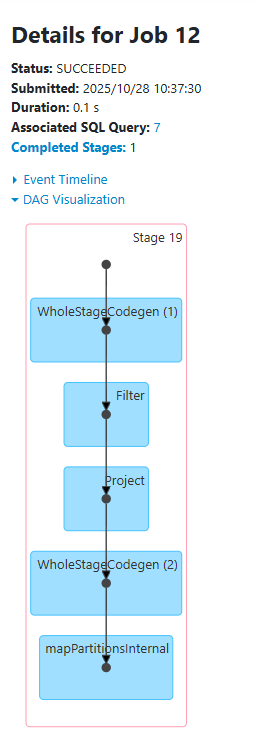

## Version Matching Spec
#### Token sets

### Similarity Metric Functions

### Version Cleaning and Normalization Function

### Tokenize and Sort Function